In [1]:
import pandas as pd

# Leitura dos CSVs dentro da pasta "data"
full_df = pd.read_csv('data/campeonato-brasileiro-full.csv')
estatisticas_df = pd.read_csv('data/campeonato-brasileiro-estatisticas-full.csv')
cartoes_df = pd.read_csv('data/campeonato-brasileiro-cartoes.csv')
gols_df = pd.read_csv('data/campeonato-brasileiro-gols.csv')


In [4]:
# Obter o conjunto de partida_id em cada base
ids_full = set(full_df['ID'])
ids_est = set(estatisticas_df['partida_id'])
ids_cartoes = set(cartoes_df['partida_id'])
ids_gols = set(gols_df['partida_id'])

# Interseção: apenas os IDs presentes em todas as 4 tabelas
ids_comuns = ids_full & ids_est & ids_cartoes & ids_gols

# Ver quantas partidas são comuns
print(f"Total de partidas em comum: {len(ids_comuns)}")


Total de partidas em comum: 3761


In [5]:
# Filtrando para manter apenas as partidas comuns
full_df = full_df[full_df['ID'].isin(ids_comuns)].reset_index(drop=True)
estatisticas_df = estatisticas_df[estatisticas_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)
cartoes_df = cartoes_df[cartoes_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)
gols_df = gols_df[gols_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)


In [6]:
# Verificando valores nulos em cada DataFrame
print("Nulos no full:", full_df.isnull().sum())
print("Nulos nas estatísticas:", estatisticas_df.isnull().sum())
print("Nulos nos cartões:", cartoes_df.isnull().sum())
print("Nulos nos gols:", gols_df.isnull().sum())

Nulos no full: ID                      0
rodata                  0
data                    0
hora                    0
mandante                0
visitante               0
formacao_mandante     330
formacao_visitante    330
tecnico_mandante        4
tecnico_visitante       3
vencedor                0
arena                   0
mandante_Placar         0
visitante_Placar        0
mandante_Estado         0
visitante_Estado        0
dtype: int64
Nulos nas estatísticas: partida_id            0
rodata                0
clube                 0
chutes                0
chutes_no_alvo        0
posse_de_bola      1404
passes                0
precisao_passes    3486
faltas                0
cartao_amarelo        0
cartao_vermelho       0
impedimentos          0
escanteios            0
dtype: int64
Nulos nos cartões: partida_id       0
rodata           0
clube            0
cartao           0
atleta           6
num_camisa     346
posicao       1114
minuto           0
dtype: int64
Nulos nos gols: partida

In [7]:
# Remover colunas irrelevantes como 'Unnamed: 0', se existir
for df in [full_df, estatisticas_df, cartoes_df, gols_df]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

# Substituir NaN por 0 nas estatísticas (ex: chutes, posse, etc.)
estatisticas_df.fillna(0, inplace=True)

# Cartões e gols — geralmente atleta não pode estar vazio
cartoes_df.dropna(subset=['atleta'], inplace=True)
gols_df.dropna(subset=['atleta'], inplace=True)

# Garantir que placares estejam completos
full_df.dropna(subset=['mandante_Placar', 'visitante_Placar'], inplace=True)


In [ ]:
# Obter o conjunto de partida_id em cada base (ajustando o nome da coluna do full_df)
ids_full = set(full_df['ID'])  # <- corrigido aqui, pois a coluna em FULL é ID e não partida_id :)
ids_est = set(estatisticas_df['partida_id'])
ids_cartoes = set(cartoes_df['partida_id'])
ids_gols = set(gols_df['partida_id'])

# Interseção: apenas os IDs presentes em todas as 4 tabelas
ids_comuns = ids_full & ids_est & ids_cartoes & ids_gols

# Ver quantas partidas são comuns
print(f"Total de partidas em comum: {len(ids_comuns)}")


Total de partidas em comum: 3761


In [9]:
# Ajustar a coluna do full_df para que todas tenham a mesma estrutura
full_df['partida_id'] = full_df['ID']  # cria uma nova coluna 'partida_id' baseada em 'ID'

# Filtrar os DataFrames
full_df = full_df[full_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)
estatisticas_df = estatisticas_df[estatisticas_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)
cartoes_df = cartoes_df[cartoes_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)
gols_df = gols_df[gols_df['partida_id'].isin(ids_comuns)].reset_index(drop=True)


In [10]:
# Garantir que nomes dos clubes estejam padronizados
estatisticas_df['clube'] = estatisticas_df['clube'].str.strip()
full_df['mandante'] = full_df['mandante'].str.strip()
full_df['visitante'] = full_df['visitante'].str.strip()

# Estatísticas do mandante
estat_mandante = estatisticas_df.merge(
    full_df[['partida_id', 'mandante']],
    left_on=['partida_id', 'clube'],
    right_on=['partida_id', 'mandante'],
    how='inner'
)

# Estatísticas do visitante
estat_visitante = estatisticas_df.merge(
    full_df[['partida_id', 'visitante']],
    left_on=['partida_id', 'clube'],
    right_on=['partida_id', 'visitante'],
    how='inner'
)


In [11]:
# Remover colunas duplicadas antes de renomear
estat_mandante.drop(columns=['clube', 'mandante'], inplace=True)
estat_visitante.drop(columns=['clube', 'visitante'], inplace=True)

# Adicionar prefixos
estat_mandante = estat_mandante.add_prefix('mandante_')
estat_visitante = estat_visitante.add_prefix('visitante_')

# A coluna comum para junção é 'mandante_partida_id' e 'visitante_partida_id', que são iguais


In [12]:
# Juntar as estatísticas ao full_df
df_merged = full_df.merge(
    estat_mandante,
    left_on='partida_id',
    right_on='mandante_partida_id',
    how='inner'
).merge(
    estat_visitante,
    left_on='partida_id',
    right_on='visitante_partida_id',
    how='inner'
)

# Remover colunas repetidas de ID
df_merged.drop(columns=['mandante_partida_id', 'visitante_partida_id'], inplace=True)

# Visualizar
df_merged.head()


,ID,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,...,visitante_chutes,visitante_chutes_no_alvo,visitante_posse_de_bola,visitante_passes,visitante_precisao_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios
0,4607,1,19/04/2014,18:28,Fluminense,Figueirense,NaN,NaN,C. Borges dos Santos,V. Eutrópio,...,0,0,0,0,0,0,0,0,0,0
1,4608,1,19/04/2014,18:31,Internacional,Vitoria,NaN,NaN,A. da Silva Braga,N. da Silveira Júnior,...,0,0,0,0,0,0,0,0,0,0
2,4612,1,20/04/2014,15:58,Bahia,Cruzeiro,NaN,NaN,M. dos Santos Gonçalves,M. de Oliveira Santos,...,0,0,0,0,0,0,0,0,0,0
3,4611,1,20/04/2014,15:59,Sao Paulo,Botafogo-RJ,NaN,NaN,M. Ramalho,V. Carmo Mancini,...,0,0,0,0,0,0,0,0,0,0
4,4610,1,20/04/2014,16:00,Athletico-PR,Gremio,NaN,NaN,M. Portugal Vicario,E. Alves Moreira,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Função para determinar resultado da partida
def definir_resultado(row):
    if row['mandante_Placar'] > row['visitante_Placar']:
        return 'Mandante'
    elif row['mandante_Placar'] < row['visitante_Placar']:
        return 'Visitante'
    else:
        return 'Empate'

# Aplicar a função
df_merged['resultado'] = df_merged.apply(definir_resultado, axis=1)


In [14]:
# Verificar tipo de dado
print(df_merged['mandante_posse_de_bola'].dtype)

# Converter para float, removendo '%', se necessário
df_merged['mandante_posse_de_bola'] = (
    df_merged['mandante_posse_de_bola']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

df_merged['visitante_posse_de_bola'] = (
    df_merged['visitante_posse_de_bola']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)


object


In [19]:
# Função para extrair posse de bola do vencedor
def posse_vencedor(row):
    if row['resultado'] == 'Mandante':
        return row['mandante_posse_de_bola']
    elif row['resultado'] == 'Visitante':
        return row['visitante_posse_de_bola']
    else:
        return None  # empate

def posse_perdedor(row):
    if row['resultado'] == 'Mandante':
        return row['visitante_posse_de_bola']
    elif row['resultado'] == 'Visitante':
        return row['mandante_posse_de_bola']
    else:
        return None

df_merged['posse_vencedor'] = df_merged.apply(posse_vencedor, axis=1)
df_merged['posse_perdedor'] = df_merged.apply(posse_perdedor, axis=1)


C:\Users\Kami\AppData\Local\Temp\ipykernel_23568\4068851537.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=valores, palette='viridis')


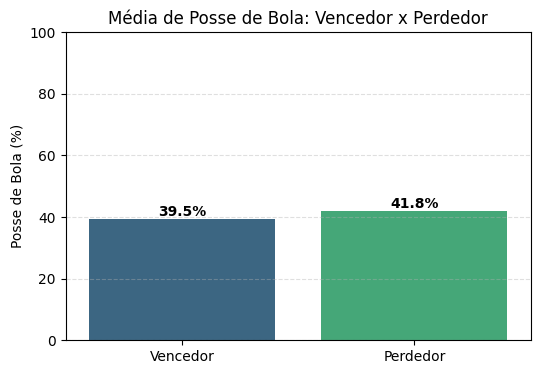

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

# Calcular média de posse de bola
media_posse = {
    'Vencedor': df_merged['posse_vencedor'].mean(),
    'Perdedor': df_merged['posse_perdedor'].mean()
}

# Preparar os dados
labels = list(media_posse.keys())
valores = list(media_posse.values())

# Plotar gráfico de barras
plt.figure(figsize=(6,4))
ax = sns.barplot(x=labels, y=valores, palette='viridis')

# Adicionar rótulos numéricos no topo de cada barra
for i, v in enumerate(valores):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.title('Média de Posse de Bola: Vencedor x Perdedor')
plt.ylabel('Posse de Bola (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()



In [22]:
df_merged.groupby('resultado')[['mandante_posse_de_bola', 'visitante_posse_de_bola']].mean().round(1)


,mandante_posse_de_bola,visitante_posse_de_bola
resultado,,
Empate,42.4,39.1
Mandante,40.7,40.7
Visitante,44.0,37.1


C:\Users\Kami\AppData\Local\Temp\ipykernel_23568\1517431402.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vitorias.index, y=vitorias.values, palette='Set2')


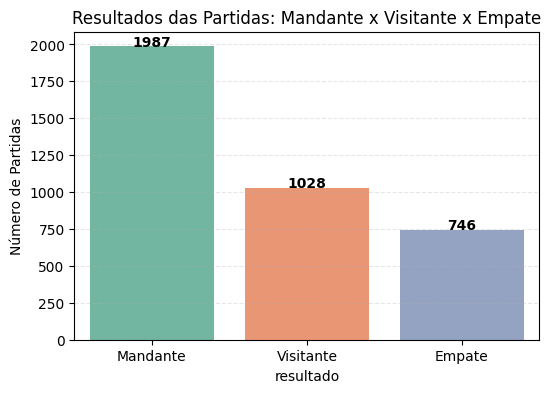

In [24]:
# Contagem de vitórias por tipo de resultado
vitorias = df_merged['resultado'].value_counts()

# Visualização
plt.figure(figsize=(6,4))
sns.barplot(x=vitorias.index, y=vitorias.values, palette='Set2')

# Adicionar rótulos
for i, v in enumerate(vitorias.values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.title('Resultados das Partidas: Mandante x Visitante x Empate')
plt.ylabel('Número de Partidas')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [25]:
# Calcular proporções
proporcao = df_merged['resultado'].value_counts(normalize=True).round(3) * 100
print(proporcao)


resultado
Mandante     52.8
Visitante    27.3
Empate       19.8
Name: proportion, dtype: float64


In [ ]:
from pandasql import sqldf

# Criar query SQL - SQLite
query = """
SELECT resultado, COUNT(*) as total_partidas,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df_merged), 2) as porcentagem
FROM df_merged
GROUP BY resultado
ORDER BY total_partidas DESC
"""

# Executar
sqldf(query)


,resultado,total_partidas,porcentagem
0,Mandante,1987,52.83
1,Visitante,1028,27.33
2,Empate,746,19.84


In [28]:
media_gols = {
    'Mandante': df_merged['mandante_Placar'].mean(),
    'Visitante': df_merged['visitante_Placar'].mean()
}


C:\Users\Kami\AppData\Local\Temp\ipykernel_23568\733021915.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=valores, palette='Blues')


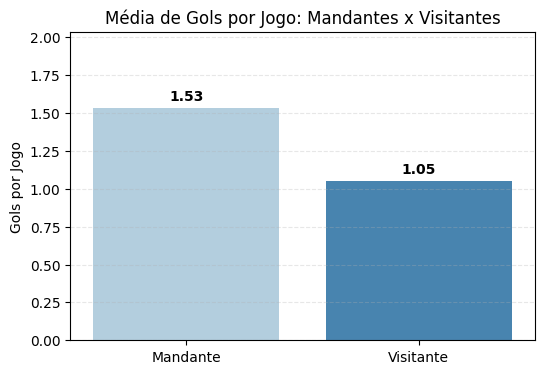

In [ ]:
# Calculo de medias de gols por jogos 

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(media_gols.keys())
valores = list(media_gols.values())

plt.figure(figsize=(6,4))
ax = sns.barplot(x=labels, y=valores, palette='Blues')

# Adiciona rótulos nas barras
for i, v in enumerate(valores):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.title('Média de Gols por Jogo: Mandantes x Visitantes')
plt.ylabel('Gols por Jogo')
plt.ylim(0, max(valores) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [30]:
query = """
SELECT
  ROUND(AVG(mandante_Placar), 2) AS media_gols_mandante,
  ROUND(AVG(visitante_Placar), 2) AS media_gols_visitante
FROM df_merged
"""
sqldf(query)


,media_gols_mandante,media_gols_visitante
0,1.53,1.05


In [33]:
# Lista de colunas que queremos comparar
colunas_estatisticas = [
    'mandante_chutes', 'visitante_chutes',
    'mandante_chutes_no_alvo', 'visitante_chutes_no_alvo',
    'mandante_escanteios', 'visitante_escanteios',
    'mandante_cartao_amarelo', 'visitante_cartao_amarelo',
    'mandante_cartao_vermelho', 'visitante_cartao_vermelho'
]

# Agrupar por resultado e calcular a média
medias_estatisticas = df_merged.groupby('resultado')[colunas_estatisticas].mean().round(1)

# Visualizar
medias_estatisticas


,mandante_chutes,visitante_chutes,mandante_chutes_no_alvo,visitante_chutes_no_alvo,mandante_escanteios,visitante_escanteios,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho
resultado,,,,,,,,,,
Empate,12.0,9.5,3.1,2.6,4.8,3.8,1.9,2.1,0.1,0.1
Mandante,11.8,8.9,3.5,2.0,4.6,3.8,1.8,1.9,0.0,0.1
Visitante,12.0,9.4,2.7,3.1,5.2,3.3,1.9,2.1,0.1,0.1


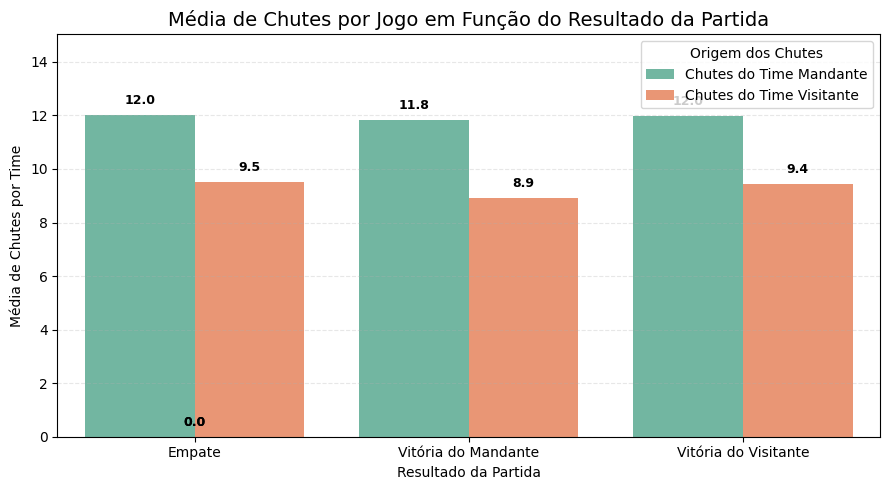

In [ ]:
plt.figure(figsize=(9,5))
ax = sns.barplot(data=chutes_long, x='resultado_legivel', y='Média de Chutes', hue='Time', palette='Set2')

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.3:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 0.2, f'{altura:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Chutes por Jogo em Função do Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Chutes por Time')
plt.ylim(0, chutes_long['Média de Chutes'].max() + 3)
plt.legend(title='Origem dos Chutes', loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



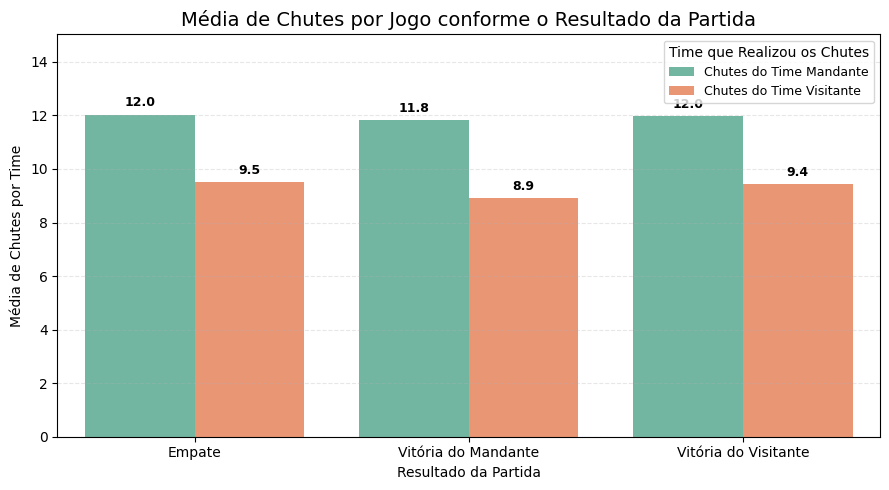

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=chutes_long,
    x='resultado_legivel',
    y='Média de Chutes',
    hue='Time',
    palette='Set2'
)

# Adicionar valores acima das barras, ignorando barras com altura quase nula
for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.3:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            altura + 0.2,
            f'{altura:.1f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

# Título e eixos
plt.title('Média de Chutes por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Chutes por Time')
plt.ylim(0, chutes_long['Média de Chutes'].max() + 3)

# Legenda tradicional no canto superior direito
plt.legend(
    title='Time que Realizou os Chutes',
    loc='upper right',
    fontsize=9,
    title_fontsize=10
)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



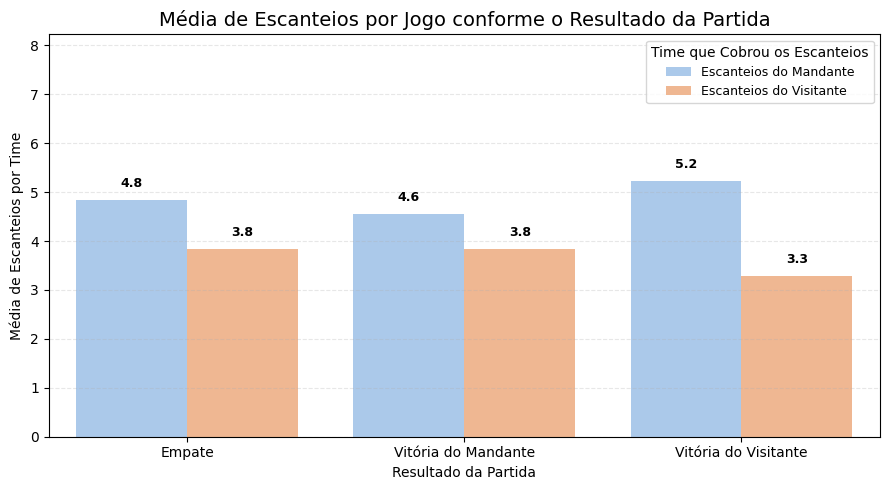

In [50]:
#Escanteio 
# Preparar dados
df_esc = df_merged[['resultado', 'mandante_escanteios', 'visitante_escanteios']].copy()
df_esc['resultado_legivel'] = df_esc['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_esc['mandante_escanteios'] = pd.to_numeric(df_esc['mandante_escanteios'], errors='coerce')
df_esc['visitante_escanteios'] = pd.to_numeric(df_esc['visitante_escanteios'], errors='coerce')

# Calcular médias
esc_medias = (
    df_esc.groupby('resultado_legivel')[['mandante_escanteios', 'visitante_escanteios']]
    .mean().reset_index()
)

esc_long = esc_medias.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Escanteios'
)

esc_long['Time'] = esc_long['Time'].map({
    'mandante_escanteios': 'Escanteios do Mandante',
    'visitante_escanteios': 'Escanteios do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(data=esc_long, x='resultado_legivel', y='Média de Escanteios', hue='Time', palette='pastel')

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.3:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 0.2, f'{altura:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Escanteios por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Escanteios por Time')
plt.ylim(0, esc_long['Média de Escanteios'].max() + 3)
plt.legend(title='Time que Cobrou os Escanteios', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


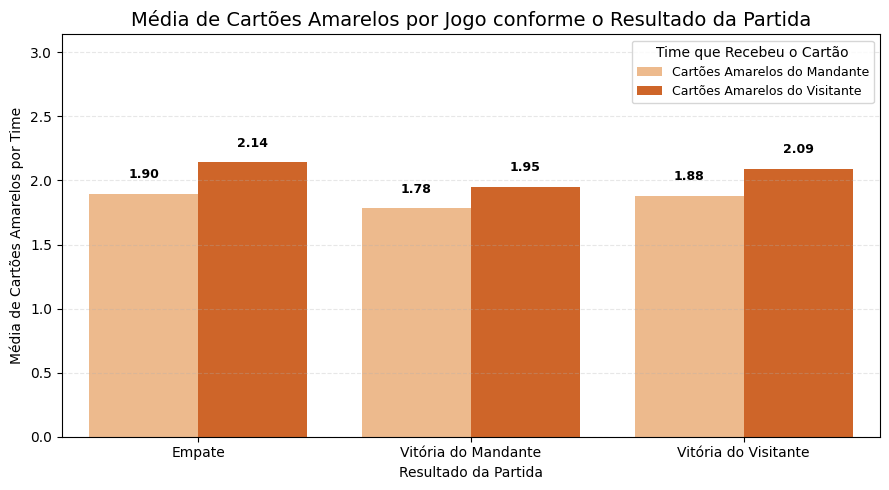

In [51]:
#Cartões amarelos
# Preparar dados
df_cart = df_merged[['resultado', 'mandante_cartao_amarelo', 'visitante_cartao_amarelo']].copy()
df_cart['resultado_legivel'] = df_cart['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_cart['mandante_cartao_amarelo'] = pd.to_numeric(df_cart['mandante_cartao_amarelo'], errors='coerce')
df_cart['visitante_cartao_amarelo'] = pd.to_numeric(df_cart['visitante_cartao_amarelo'], errors='coerce')

# Calcular médias
cart_medias = (
    df_cart.groupby('resultado_legivel')[['mandante_cartao_amarelo', 'visitante_cartao_amarelo']]
    .mean().reset_index()
)

cart_long = cart_medias.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Cartões Amarelos'
)

cart_long['Time'] = cart_long['Time'].map({
    'mandante_cartao_amarelo': 'Cartões Amarelos do Mandante',
    'visitante_cartao_amarelo': 'Cartões Amarelos do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(data=cart_long, x='resultado_legivel', y='Média de Cartões Amarelos', hue='Time', palette='Oranges')

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.1:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 0.1, f'{altura:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Cartões Amarelos por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Cartões Amarelos por Time')
plt.ylim(0, cart_long['Média de Cartões Amarelos'].max() + 1)
plt.legend(title='Time que Recebeu o Cartão', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


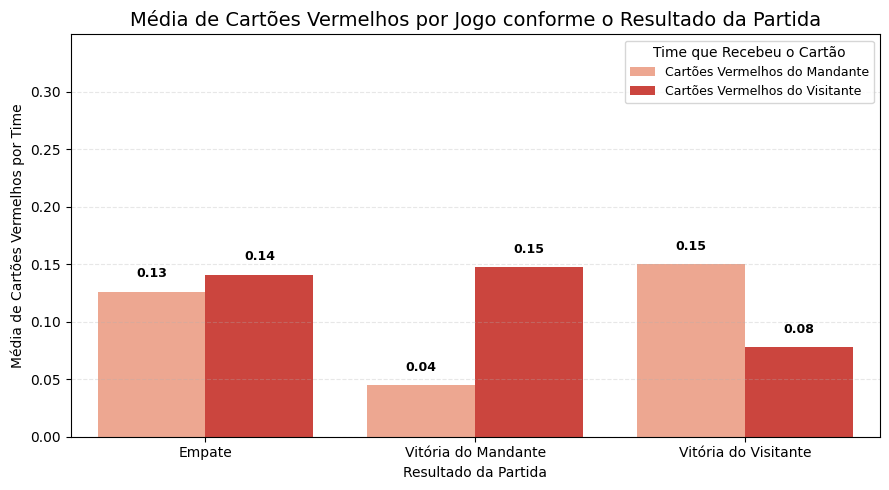

In [52]:
#Cartões Vermelhos
# Preparar dados
df_vermelhos = df_merged[['resultado', 'mandante_cartao_vermelho', 'visitante_cartao_vermelho']].copy()
df_vermelhos['resultado_legivel'] = df_vermelhos['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_vermelhos['mandante_cartao_vermelho'] = pd.to_numeric(df_vermelhos['mandante_cartao_vermelho'], errors='coerce')
df_vermelhos['visitante_cartao_vermelho'] = pd.to_numeric(df_vermelhos['visitante_cartao_vermelho'], errors='coerce')

# Calcular médias
vermelhos_medio = (
    df_vermelhos.groupby('resultado_legivel')[['mandante_cartao_vermelho', 'visitante_cartao_vermelho']]
    .mean().reset_index()
)

vermelhos_long = vermelhos_medio.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Cartões Vermelhos'
)

vermelhos_long['Time'] = vermelhos_long['Time'].map({
    'mandante_cartao_vermelho': 'Cartões Vermelhos do Mandante',
    'visitante_cartao_vermelho': 'Cartões Vermelhos do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=vermelhos_long,
    x='resultado_legivel',
    y='Média de Cartões Vermelhos',
    hue='Time',
    palette='Reds'
)

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.01:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 0.01, f'{altura:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Cartões Vermelhos por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Cartões Vermelhos por Time')
plt.ylim(0, vermelhos_long['Média de Cartões Vermelhos'].max() + 0.2)
plt.legend(title='Time que Recebeu o Cartão', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


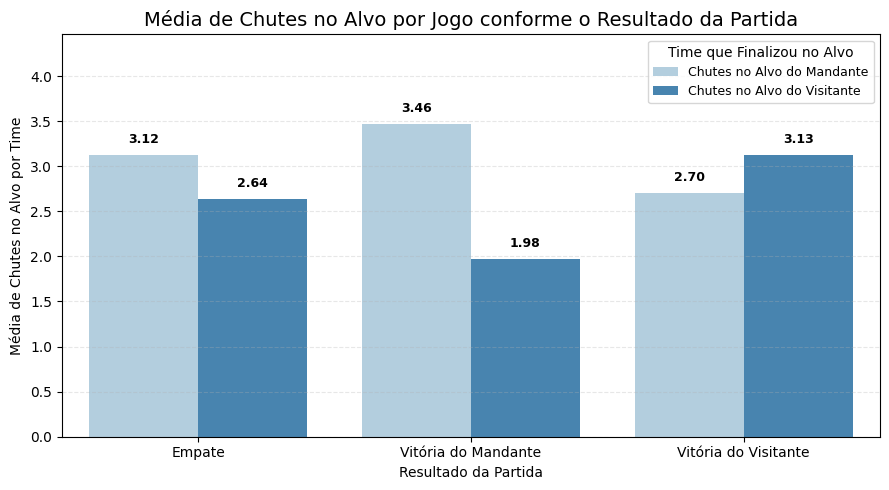

In [53]:
# Chutes no Alvo por Resultado
# Preparar dados
df_alvo = df_merged[['resultado', 'mandante_chutes_no_alvo', 'visitante_chutes_no_alvo']].copy()
df_alvo['resultado_legivel'] = df_alvo['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_alvo['mandante_chutes_no_alvo'] = pd.to_numeric(df_alvo['mandante_chutes_no_alvo'], errors='coerce')
df_alvo['visitante_chutes_no_alvo'] = pd.to_numeric(df_alvo['visitante_chutes_no_alvo'], errors='coerce')

# Calcular médias
alvo_medio = (
    df_alvo.groupby('resultado_legivel')[['mandante_chutes_no_alvo', 'visitante_chutes_no_alvo']]
    .mean().reset_index()
)

alvo_long = alvo_medio.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Chutes no Alvo'
)

alvo_long['Time'] = alvo_long['Time'].map({
    'mandante_chutes_no_alvo': 'Chutes no Alvo do Mandante',
    'visitante_chutes_no_alvo': 'Chutes no Alvo do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=alvo_long,
    x='resultado_legivel',
    y='Média de Chutes no Alvo',
    hue='Time',
    palette='Blues'
)

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.2:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 0.1, f'{altura:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Chutes no Alvo por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Chutes no Alvo por Time')
plt.ylim(0, alvo_long['Média de Chutes no Alvo'].max() + 1)
plt.legend(title='Time que Finalizou no Alvo', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


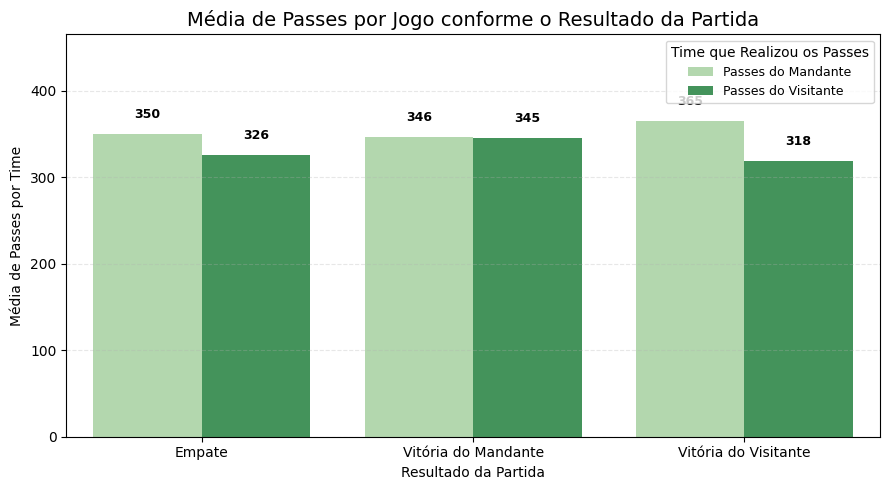

In [54]:
# Media por Passes
# Preparar dados
df_passes = df_merged[['resultado', 'mandante_passes', 'visitante_passes']].copy()
df_passes['resultado_legivel'] = df_passes['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_passes['mandante_passes'] = pd.to_numeric(df_passes['mandante_passes'], errors='coerce')
df_passes['visitante_passes'] = pd.to_numeric(df_passes['visitante_passes'], errors='coerce')

# Calcular médias
passes_medio = (
    df_passes.groupby('resultado_legivel')[['mandante_passes', 'visitante_passes']]
    .mean().reset_index()
)

passes_long = passes_medio.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Passes'
)

passes_long['Time'] = passes_long['Time'].map({
    'mandante_passes': 'Passes do Mandante',
    'visitante_passes': 'Passes do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=passes_long,
    x='resultado_legivel',
    y='Média de Passes',
    hue='Time',
    palette='Greens'
)

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 10:
        ax.text(bar.get_x() + bar.get_width()/2, altura + 15, f'{altura:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Média de Passes por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Passes por Time')
plt.ylim(0, passes_long['Média de Passes'].max() + 100)
plt.legend(title='Time que Realizou os Passes', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


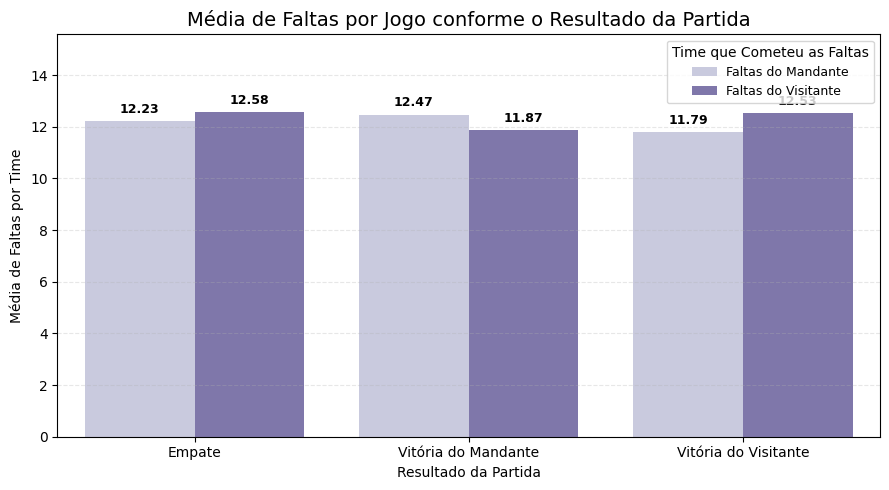

In [60]:
# Faltas
# Preparar dados
df_faltas = df_merged[['resultado', 'mandante_faltas', 'visitante_faltas']].copy()
df_faltas['resultado_legivel'] = df_faltas['resultado'].map({
    'Mandante': 'Vitória do Mandante',
    'Visitante': 'Vitória do Visitante',
    'Empate': 'Empate'
})
df_faltas['mandante_faltas'] = pd.to_numeric(df_faltas['mandante_faltas'], errors='coerce')
df_faltas['visitante_faltas'] = pd.to_numeric(df_faltas['visitante_faltas'], errors='coerce')

# Calcular médias
faltas_medio = (
    df_faltas.groupby('resultado_legivel')[['mandante_faltas', 'visitante_faltas']]
    .mean().reset_index()
)

faltas_long = faltas_medio.melt(
    id_vars='resultado_legivel',
    var_name='Time',
    value_name='Média de Faltas'
)

faltas_long['Time'] = faltas_long['Time'].map({
    'mandante_faltas': 'Faltas do Mandante',
    'visitante_faltas': 'Faltas do Visitante'
})

# Gráfico
plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=faltas_long,
    x='resultado_legivel',
    y='Média de Faltas',
    hue='Time',
    palette='Purples'
)

for bar in ax.patches:
    altura = bar.get_height()
    if altura > 0.3:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            altura + 0.2,
            f'{altura:.2f}',  # Mostra valor com duas casas decimais
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

plt.title('Média de Faltas por Jogo conforme o Resultado da Partida', fontsize=14)
plt.xlabel('Resultado da Partida')
plt.ylabel('Média de Faltas por Time')
plt.ylim(0, faltas_long['Média de Faltas'].max() + 3)
plt.legend(title='Time que Cometeu as Faltas', loc='upper right', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()




C:\Users\Kami\AppData\Local\Temp\ipykernel_23568\2389756669.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(media_posse.keys()), y=list(media_posse.values()), palette='viridis')


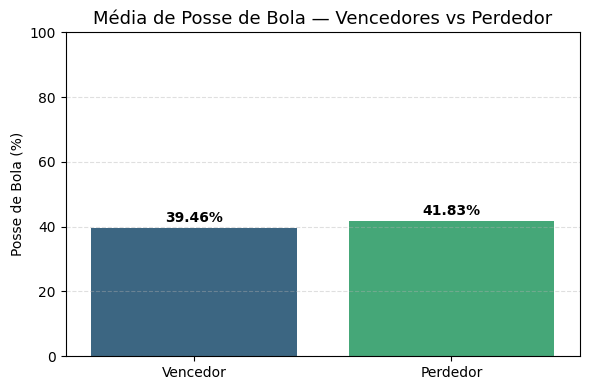

In [61]:
# Calcular quem venceu e perdeu
df_posse = df_merged.copy()

# Converter para numérico
df_posse['mandante_posse_de_bola'] = pd.to_numeric(df_posse['mandante_posse_de_bola'], errors='coerce')
df_posse['visitante_posse_de_bola'] = pd.to_numeric(df_posse['visitante_posse_de_bola'], errors='coerce')

# Criar colunas de posse para vencedor e perdedor
df_posse['posse_vencedor'] = df_posse.apply(
    lambda row: row['mandante_posse_de_bola'] if row['resultado'] == 'Mandante'
    else (row['visitante_posse_de_bola'] if row['resultado'] == 'Visitante' else None),
    axis=1
)

df_posse['posse_perdedor'] = df_posse.apply(
    lambda row: row['visitante_posse_de_bola'] if row['resultado'] == 'Mandante'
    else (row['mandante_posse_de_bola'] if row['resultado'] == 'Visitante' else None),
    axis=1
)

# Calcular média
media_posse = {
    'Vencedor': df_posse['posse_vencedor'].mean(),
    'Perdedor': df_posse['posse_perdedor'].mean()
}

# Gráfico
plt.figure(figsize=(6, 4))
sns.barplot(x=list(media_posse.keys()), y=list(media_posse.values()), palette='viridis')

# Adicionar valores
for i, v in enumerate(media_posse.values()):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Média de Posse de Bola — Vencedores vs Perdedor', fontsize=13)
plt.ylabel('Posse de Bola (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Carregar os dados
full_df = pd.read_csv('data/campeonato-brasileiro-full.csv')
estatisticas_df = pd.read_csv('data/campeonato-brasileiro-estatisticas-full.csv')

# Renomear coluna 'id' para 'partida_id' em full_df
full_df.rename(columns={'ID': 'partida_id'}, inplace=True)

# Realizar merge entre as tabelas
df_merged = full_df.merge(estatisticas_df, on='partida_id', how='inner')



In [17]:
# Adiciona colunas mandante e visitante à estatísticas
estatisticas_df = estatisticas_df.merge(
    full_df[['partida_id', 'mandante', 'visitante']],
    on='partida_id',
    how='left'
)


In [18]:
# Mandante
estat_mandante = estatisticas_df[estatisticas_df['clube'] == estatisticas_df['mandante']].copy()
estat_mandante = estat_mandante.drop(columns=['clube', 'visitante'])
estat_mandante = estat_mandante.add_prefix('mandante_')
estat_mandante.rename(columns={'mandante_partida_id': 'partida_id'}, inplace=True)

# Visitante
estat_visitante = estatisticas_df[estatisticas_df['clube'] == estatisticas_df['visitante']].copy()
estat_visitante = estat_visitante.drop(columns=['clube', 'mandante'])
estat_visitante = estat_visitante.add_prefix('visitante_')
estat_visitante.rename(columns={'visitante_partida_id': 'partida_id'}, inplace=True)


In [19]:
df_merged = full_df.merge(estat_mandante, on='partida_id')
df_merged = df_merged.merge(estat_visitante, on='partida_id')


In [20]:
def definir_resultado(row):
    if row['vencedor'] == row['mandante']:
        return 'Mandante'
    elif row['vencedor'] == row['visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df_merged['resultado'] = df_merged.apply(definir_resultado, axis=1)


In [16]:
#Inspecionando as colunas 
print(df_merged.columns.tolist())


['partida_id', 'rodata_x', 'data', 'hora', 'mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'tecnico_mandante', 'tecnico_visitante', 'vencedor', 'arena', 'mandante_Placar', 'visitante_Placar', 'mandante_Estado', 'visitante_Estado', 'rodata_y', 'clube', 'chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'faltas', 'cartao_amarelo', 'cartao_vermelho', 'impedimentos', 'escanteios']
